In [1455]:
from pathlib import Path


from matplotlib import rcParams
from matplotlib.cm import rainbow
import math
import numpy as np
import pandas as pd


from math import sin, cos, sqrt, atan2, radians


from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn import  linear_model

from collections import Counter

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

#Training
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


pd.set_option("display.max_columns", 100)




/kaggle/input/fare-classification/meta_data.csv
/kaggle/input/ml-dataset/ML data/sample_submission.csv
/kaggle/input/ml-dataset/ML data/test.csv
/kaggle/input/ml-dataset/ML data/train.csv


In [1456]:
R = 6373.0

#lable encording
def encoding_label(label):
  if(label=='correct'):
    return 1
  else:
    return 0
#calculate hours
def calculate_time(time):
    hours=time.total_seconds()
    return hours    
#calculate distance
def calculate_distance(coordinates):

#     print(coordinates['pick_lat'])
#     print(type(coordinates['pick_lat']))
    lat1 = math.radians(coordinates['pick_lat'])
    lon1 = math.radians(coordinates['pick_lon'])
    lat2 = math.radians(coordinates['drop_lat'])
    lon2 = math.radians(coordinates['drop_lon'])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

#Finging outliers
def calculate_outliers(data,features):
    out_liers=[]
    for feature in features:
        column_data= data[[feature]]
#         column_data.head()
        print(feature)
        column_data.sort_values(by=[feature], inplace=True)
        
        q1, q3= np.percentile(column_data,[5,99.9])
        iqr = q3 - q1
#         lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr) 
        print(q1)
        print(q3)
#         outlier_list_col = column_data[(column_data < lower_bound) | (column_data > upper_bound)].index
        outlier_list_col = column_data[ (column_data > upper_bound)].index
        out_liers.extend(outlier_list_col)
    out_liers=Counter(out_liers)
    print(out_liers)
    out_liers = list(index for index,count in out_liers.items() if count > 2)
    column_data.head()
    return out_liers


def optimize_farevalue(record): 
        fare_per_distance=record['fare']/record['distance']
        fare_per_distance_per_second= fare_per_distance/record['time_difference']
        return fare_per_distance_per_second
def meter_waiting_fare_per_meter_waiting(record):
        if(record['meter_waiting']==0):
            return record['meter_waiting_fare']
        return record['meter_waiting_fare']/record['meter_waiting']
    
# def time_difference_per_fare(record):
#         if(record['fare']== 0):
#             return record['time_difference']
#         else:
#             return record['time_difference']/record['fare']
        
def fare_per_duration(record):
        if(record['fare']== 0):
            return record['duration']
        else:
            return record['duration']/record['fare']

def fare_per_distance(record):
        if(record['distance']==0):
            return record['fare']
        else:
            return record['fare']/record['distance']

def distance_per_duration(record):
        if(record['duration']==0):
            return record['duration']
        else:
            return record['distance']/record['duration']

Definition

In [1457]:

train_data = pd.read_csv("/kaggle/input/ml-dataset/ML data/train.csv", index_col="tripid")
train_data["label"]=train_data["label"].apply(encoding_label).values
test_data = pd.read_csv("/kaggle/input/ml-dataset/ML data/test.csv", index_col="tripid")
submissionFormatData = pd.read_csv("/kaggle/input/ml-dataset/ML data/sample_submission.csv", index_col="tripid")
#training_data=train_data["label"]
# index_data=test_data["tripid"]
# train_data.head()
# Trainng_feature=train_data[]
# trainng_feature= train_data.loc[:,[0:12]]


# trainng_label.head()
# test_data.head()
# train_data.columns.values
# train_data.dropna()
# train_data.dropna()

Removing outliers

In [1458]:
print(len(train_data.index))

17176


In [1459]:
train_data[train_data["label"]==0]["additional_fare"]

tripid
189135814    10.5
189140969    10.5
189147041    10.5
189157607    10.5
189160756    10.5
             ... 
213674502     NaN
213689462    40.5
213703973    40.5
213758346     NaN
213795752    40.5
Name: additional_fare, Length: 1681, dtype: float64

In [1460]:
#train_data=train_data[(train_data['additional_fare']< 80)&(train_data['duration']< 330000)&(train_data['meter_waiting'] <400000)&(train_data['meter_waiting_fare']<22000)&(train_data['meter_waiting_till_pickup']<40000)&(train_data['fare']< 28000)]

#train_data=train_data[(train_data['additional_fare']< 220)&(train_data['duration']< 400000)&(train_data['meter_waiting'] <400000)&(train_data['meter_waiting_fare']<22000)&(train_data['meter_waiting_till_pickup']<40000)&(train_data['fare']< 25097)]

# train_data=train_data[(train_data['additional_fare']< 100)&(train_data['duration']< 400000)&(train_data['meter_waiting'] <400000)&(train_data['meter_waiting_fare']<22000)&(train_data['meter_waiting_till_pickup']<40000)&(train_data['fare']< 28000)]
#train_data=train_data[(train_data['duration']< 100000)&(train_data['meter_waiting'] <100000)&(train_data['meter_waiting_fare']<6000)&(train_data['meter_waiting_till_pickup']<4000)&(train_data['fare']< 8000)]

In [1461]:
train_data[train_data["label"]==0]["additional_fare"]

tripid
189135814    10.5
189140969    10.5
189147041    10.5
189157607    10.5
189160756    10.5
             ... 
213674502     NaN
213689462    40.5
213703973    40.5
213758346     NaN
213795752    40.5
Name: additional_fare, Length: 1681, dtype: float64

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


Text(0, 0.5, 'duration ($)')

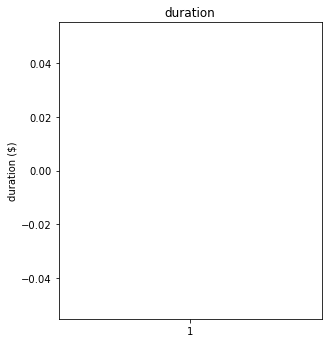

In [1462]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['duration'], showmeans = True, meanline = True)
plt.title('duration')
plt.ylabel('duration ($)')

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


Text(0, 0.5, 'meter_waiting ($)')

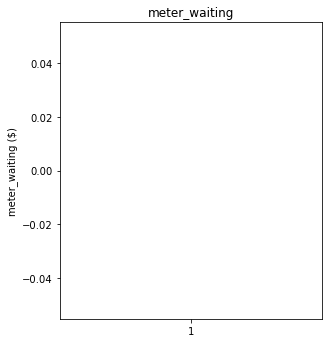

In [1463]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['meter_waiting'], showmeans = True, meanline = True)
plt.title('meter_waiting')
plt.ylabel('meter_waiting ($)')

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


Text(0, 0.5, 'meter_waiting_fare ($)')

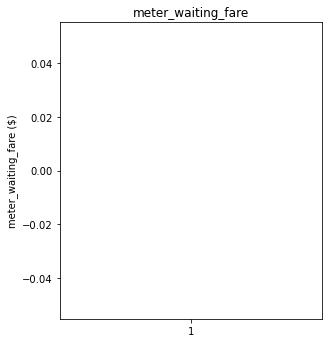

In [1464]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['meter_waiting_fare'], showmeans = True, meanline = True)
plt.title('meter_waiting_fare')
plt.ylabel('meter_waiting_fare ($)')


/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


Text(0, 0.5, 'meter_waiting_till_pickup ($)')

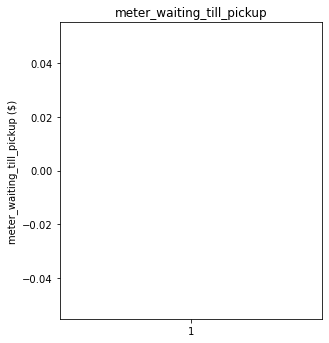

In [1465]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['meter_waiting_till_pickup'], showmeans = True, meanline = True)
plt.title('meter_waiting_till_pickup')
plt.ylabel('meter_waiting_till_pickup ($)')

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


Text(0, 0.5, 'fare ($)')

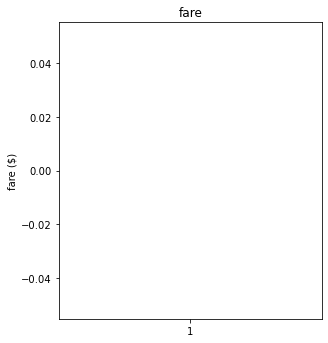

In [1466]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['fare'], showmeans = True, meanline = True)
plt.title('fare')
plt.ylabel('fare ($)')

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


Text(0, 0.5, 'additional_fare ($)')

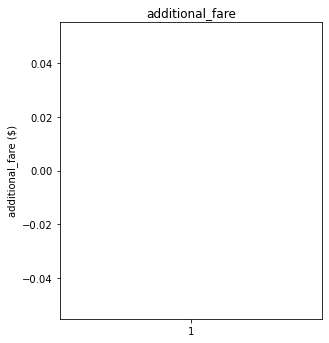

In [1467]:
#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=train_data['additional_fare'], showmeans = True, meanline = True)
plt.title('additional_fare')
plt.ylabel('additional_fare ($)')


In [1468]:
print(len(train_data.index))

17176


In [1469]:
# #Reemove NAN tuples
# train_data.dropna(inplace=True)
# #dropNAN columns from test list
# NANcolumns=test_data.columns[test_data.isna().any()].tolist()
# #remove tuples from submissionData
# submissionFormatData.drop(NANcolumns)
# test_data.dropna(inplace=True)

In [1470]:
# # out_liers= calculate_outliers(train_data, ["duration","meter_waiting","meter_waiting_fare","fare","pick_lat","pick_lon","drop_lat","drop_lon"])
# # out_liers= calculate_outliers(train_data, ["additional_fare","duration","meter_waiting","meter_waiting_fare","fare"])
# out_liers= calculate_outliers(train_data, ["meter_waiting_fare"])
# out_liers
# train_data.drop(out_liers,inplace=True)

Data Preprocessing

In [1471]:
#189128020
train_data.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
tripid,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1
189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1


In [1472]:
# NANcolumns=trainng_feature.columns[trainng_feature.isna().any()].tolist()
# print(NANcolumns)

In [1473]:

train_data['pickup_time'] = pd.to_datetime(train_data['pickup_time'],format='%m/%d/%Y %H:%M')
train_data['drop_time'] = pd.to_datetime(train_data['drop_time'],format='%m/%d/%Y %H:%M')
test_data['pickup_time'] = pd.to_datetime(test_data['pickup_time'],format='%m/%d/%Y %H:%M')
test_data['drop_time'] = pd.to_datetime(test_data['drop_time'],format='%m/%d/%Y %H:%M')


train_data['time_difference']=train_data['drop_time']-train_data['pickup_time']
train_data['time_difference']=train_data['time_difference'].apply(calculate_time).values
test_data['time_difference']=test_data['drop_time']-test_data['pickup_time']
test_data['time_difference']=test_data['time_difference'].apply(calculate_time).values

#calculate distance

# trainng_feature['time_difference']=trainng_feature['time_difference'].days
# trainng_feature['pyear']=trainng_feature['pickup_time'].dt.year 
# trainng_feature['pmonth']=trainng_feature['pickup_time'].dt.month 
# trainng_feature['pday']=trainng_feature['pickup_time'].dt.day
# trainng_feature['pdayofweek_num']=trainng_feature['pickup_time'].dt.dayofweek 
# trainng_feature['pHour'] = trainng_feature['pickup_time'].dt.hour 
# trainng_feature['pminute'] = trainng_feature['pickup_time'].dt.minute 




train_data=train_data.drop(['pickup_time','drop_time'],axis=1)
test_data=test_data.drop(['pickup_time','drop_time'],axis=1)
# trainng_feature['dyear']=trainng_feature['drop_time'].dt.year 
# trainng_feature['dmonth']=trainng_feature['drop_time'].dt.month 
# trainng_feature['dday']=trainng_feature['drop_time'].dt.day
# trainng_feature['ddayofweek_num']=trainng_feature['drop_time'].dt.dayofweek 
# trainng_feature['dHour'] = trainng_feature['drop_time'].dt.hour 
# trainng_feature['dminute'] = trainng_feature['drop_time'].dt.minute 
# test_data.isnull().sum()

#merginh two dataframes
train_data["distance"]=train_data[['pick_lat','pick_lon','drop_lat','drop_lon']].apply(calculate_distance,axis = 1)
test_data["distance"]=test_data[['pick_lat','pick_lon','drop_lat','drop_lon']].apply(calculate_distance,axis = 1)
#
# trainng_feature['fare']=trainng_feature.apply(optimize_farevalue,axis = 1)
# test_data['fare']=test_data.apply(optimize_farevalue,axis = 1)
# drop columns
train_data=train_data.drop(['pick_lat','pick_lon','drop_lat','drop_lon'],axis=1)
test_data=test_data.drop(['pick_lat','pick_lon','drop_lat','drop_lon'],axis=1)




In [1474]:
train_data.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,time_difference,distance
tripid,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,1,840.0,5.094369
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,1,780.0,3.169052
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1080.0,6.307375
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,1,600.0,0.862217
189128020,NaN,NaN,NaN,NaN,NaN,358.39,1,1020.0,8.150340


In [1475]:
# df[df.name != 'Tina']

In [1476]:
# train_data = train_data[train_data["fare"]!=0]

In [1477]:
#replace duration NAN values with time difference
train_data["duration"].fillna(train_data["time_difference"], inplace = True)
#calculate duration without immobile time

In [1478]:
train_data.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,time_difference,distance
tripid,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,1,840.0,5.094369
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,1,780.0,3.169052
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1080.0,6.307375
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,1,600.0,0.862217
189128020,NaN,1020.0,NaN,NaN,NaN,358.39,1,1020.0,8.150340


In [1479]:
# NANcolumns=trainng_feature.columns[trainng_feature.isna().any()].tolist()
# print(NANcolumns)

In [1480]:
lableList=[0,1]
for lable in lableList:
      train_data[train_data['label']==lable]=train_data[train_data['label']==lable].fillna((train_data[(train_data['label']==lable)]).mean())
#     train_data[(train_data['label']==lable)]['additional_fare'].fillna((train_data[(train_data['label']==lable)]['additional_fare'].mean()), inplace = True)
#     train_data[(train_data['label']==lable)]['meter_waiting'].fillna(( train_data[(train_data['label']==lable)]['meter_waiting'].mean()), inplace = True)
#     train_data[(train_data['label']==lable)]['meter_waiting_fare'].fillna((train_data[(train_data['label']==lable)]['meter_waiting_fare'].mean()), inplace = True)
#     train_data[(train_data['label']==lable)]['meter_waiting_till_pickup'].fillna(( train_data[(train_data['label']==lable)]['meter_waiting_till_pickup'].mean()), inplace = True)
#     train_data[(train_data['label']==lable)]['fare'].fillna((train_data[(train_data['label']==lable)]['fare'].mean()), inplace = True)
      print((train_data[(train_data['label']==lable)]).mean())
   


additional_fare                26.574315
duration                     4468.965497
meter_waiting                3374.953655
meter_waiting_fare            184.741223
meter_waiting_till_pickup     162.035248
fare                          664.197850
label                           0.000000
time_difference              4467.126710
distance                        4.813707
dtype: float64
additional_fare                12.444340
duration                     1414.718425
meter_waiting                 356.655679
meter_waiting_fare             16.909938
meter_waiting_till_pickup     107.549152
fare                          277.626009
label                           1.000000
time_difference              1415.244918
distance                        4.864785
dtype: float64


In [1481]:
# train_data[train_data["label"]==0]["additional_fare"]

In [1482]:
# train_data[train_data["label"]==1]["additional_fare"]

In [1483]:
trainng_label= train_data["label"]
# trainng_feature= train_data["additional_fare","duration","meter_waiting","meter_waiting_fare","meter_waiting_till_pickup","fare","time_difference","distance" ]
trainng_feature= train_data.drop(["label"],axis=1)

In [1484]:
trainng_feature.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,time_difference,distance
tripid,,,,,,,,
189123628,10.50000,834.0,56.000000,0.000000,64.000000,270.32,840.0,5.094369
189125358,10.50000,791.0,47.000000,0.000000,134.000000,197.85,780.0,3.169052
189125719,10.50000,1087.0,80.000000,0.000000,61.000000,301.64,1080.0,6.307375
189127273,10.50000,598.0,271.000000,15.663800,68.000000,82.30,600.0,0.862217
189128020,12.44434,1020.0,356.655679,16.909938,107.549152,358.39,1020.0,8.150340


In [1485]:
# data_cleaner=[train_data['label'= 'correct'],train_data['label'= 'incorrect']]

    


In [1486]:
trainng_feature.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,time_difference,distance
tripid,,,,,,,,
189123628,10.50000,834.0,56.000000,0.000000,64.000000,270.32,840.0,5.094369
189125358,10.50000,791.0,47.000000,0.000000,134.000000,197.85,780.0,3.169052
189125719,10.50000,1087.0,80.000000,0.000000,61.000000,301.64,1080.0,6.307375
189127273,10.50000,598.0,271.000000,15.663800,68.000000,82.30,600.0,0.862217
189128020,12.44434,1020.0,356.655679,16.909938,107.549152,358.39,1020.0,8.150340


In [1487]:

trainng_feature["duration"]=trainng_feature["duration"]-trainng_feature["meter_waiting"]
test_data["duration"]=test_data["duration"]-test_data["meter_waiting"]

# trainng_feature["duration"]=trainng_feature["time_difference"]-trainng_feature["meter_waiting"]
# test_data["duration"]=test_data["time_difference"]-test_data["meter_waiting"]

#calculate fare without meter_waiting_fare
# trainng_feature["fare"]=trainng_feature["fare"]-trainng_feature["meter_waiting_fare"]
# test_data["fare"]=test_data["fare"]-test_data["meter_waiting_fare"]

trainng_feature.head()



,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,time_difference,distance
tripid,,,,,,,,
189123628,10.50000,778.000000,56.000000,0.000000,64.000000,270.32,840.0,5.094369
189125358,10.50000,744.000000,47.000000,0.000000,134.000000,197.85,780.0,3.169052
189125719,10.50000,1007.000000,80.000000,0.000000,61.000000,301.64,1080.0,6.307375
189127273,10.50000,327.000000,271.000000,15.663800,68.000000,82.30,600.0,0.862217
189128020,12.44434,663.344321,356.655679,16.909938,107.549152,358.39,1020.0,8.150340


In [1488]:
# trainng_feature["fare"]=trainng_feature["fare"]-trainng_feature["additional_fare"]-trainng_feature["meter_waiting_fare"]
# trainng_feature["duration"]=trainng_feature["duration"]/(trainng_feature["fare"]- trainng_feature["meter_waiting_fare"])
# test_data["duration"]=test_data["duration"]/(test_data["fare"]-test_data["meter_waiting_fare"])
###############################################################################
# trainng_feature["duration"]=trainng_feature["duration"]/trainng_feature["fare"]
# test_data["duration"]=test_data["duration"]/test_data["fare"]
trainng_feature["duration_per_fare"]=trainng_feature.apply(duration_per_fare,axis = 1)
test_data["duration_per_fare"]=test_data.apply(duration_per_fare,axis = 1)
# trainng_feature["time_difference"]=trainng_feature["time_difference"]/trainng_feature["fare"]
# test_data["time_difference"]=test_data["time_difference"]/test_data["fare"]


# trainng_feature["time_difference_per_fare"]=trainng_feature.apply(time_difference_per_fare,axis = 1)
# test_data["time_difference_per_fare"]=test_data.apply(time_difference_per_fare,axis = 1)
###############################################################################


# trainng_feature["meter_waiting_till_pickup"]=trainng_feature["meter_waiting_till_pickup"]/trainng_feature["fare"]
# test_data["meter_waiting_till_pickup"]=test_data["meter_waiting_till_pickup"]/test_data["fare"]

# trainng_feature["meter_waiting_till_pickup"]=trainng_feature["distance"]
# test_data["meter_waiting_till_pickup"]=test_data["distance"]

# trainng_feature["fare"]=trainng_feature["fare"]/trainng_feature["distance"]
# test_data["fare"]=test_data["fare"]/test_data["distance"]

trainng_feature['meter_waiting_fare_per_meter_waiting']=trainng_feature.apply(meter_waiting_fare_per_meter_waiting,axis = 1)
test_data['meter_waiting_fare_per_meter_waiting']=test_data.apply(meter_waiting_fare_per_meter_waiting,axis = 1)

trainng_feature['fare_per_distance']=trainng_feature.apply(fare_per_distance,axis = 1)
test_data['fare_per_distance']=test_data.apply(fare_per_distance,axis = 1)

# trainng_feature["meter_waiting_till_pickup"]=trainng_feature["meter_waiting_till_pickup"]/trainng_feature["additional_fare"]
# test_data["meter_waiting_till_pickup"]=test_data["meter_waiting_till_pickup"]/test_data["additional_fare"]

trainng_feature['distance_per_duration']=trainng_feature.apply(distance_per_duration,axis = 1)
test_data['distance_per_duration']=test_data.apply(distance_per_duration,axis = 1)

# trainng_feature["meter_waiting"]=trainng_feature["meter_waiting"]/3600
# test_data["meter_waiting"]=test_data["meter_waiting"]/3600

# trainng_feature["fare"]=trainng_feature["fare"]/trainng_feature["distance"]
# test_data["fare"]=test_data["fare"]/test_data["distance"]


trainng_feature.head()


,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,time_difference,distance,duration_per_fare,meter_waiting_fare_per_meter_waiting,fare_per_distance,distance_per_duration
tripid,,,,,,,,,,,,
189123628,10.50000,778.000000,56.000000,0.000000,64.000000,270.32,840.0,5.094369,2.878070,0.000000,53.062512,0.006548
189125358,10.50000,744.000000,47.000000,0.000000,134.000000,197.85,780.0,3.169052,3.760425,0.000000,62.431918,0.004259
189125719,10.50000,1007.000000,80.000000,0.000000,61.000000,301.64,1080.0,6.307375,3.338417,0.000000,47.823385,0.006264
189127273,10.50000,327.000000,271.000000,15.663800,68.000000,82.30,600.0,0.862217,3.973269,0.057800,95.451642,0.002637
189128020,12.44434,663.344321,356.655679,16.909938,107.549152,358.39,1020.0,8.150340,1.850901,0.047413,43.972399,0.012287


In [1489]:
train_data[train_data["distance"]==0]

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,label,time_difference,distance
tripid,,,,,,,,,
189302363,5.0,86.0,83.0,4.83890,0.0,64.83,1,60.0,0.0
189312263,10.5,287.0,286.0,1.15600,8.0,71.39,0,300.0,0.0
190189406,10.5,1958.0,834.0,48.62220,133.0,233.89,1,1920.0,0.0
190236017,5.0,27.0,10.0,0.58300,0.0,60.58,1,0.0,0.0
191410959,5.0,38.0,32.0,1.86560,0.0,61.86,1,60.0,0.0
191465398,5.0,30.0,23.0,1.34090,0.0,61.34,1,0.0,0.0
193054532,5.0,25.0,19.0,1.10770,0.0,61.10,1,0.0,0.0
194228713,10.5,917.0,26.0,0.00000,171.0,60.50,0,900.0,0.0
195271934,5.0,33.0,26.0,1.51580,0.0,61.51,1,0.0,0.0


In [1490]:
# trainng_feature[train_data["additional_fare"]==0]

In [1491]:
NANcolumns=trainng_feature.columns[trainng_feature.isna().any()].tolist()
print(NANcolumns)

[]


In [1492]:
#feature engineering




trainng_feature.head()
# trainng_feature.isnull().sum()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,time_difference,distance,duration_per_fare,meter_waiting_fare_per_meter_waiting,fare_per_distance,distance_per_duration
tripid,,,,,,,,,,,,
189123628,10.50000,778.000000,56.000000,0.000000,64.000000,270.32,840.0,5.094369,2.878070,0.000000,53.062512,0.006548
189125358,10.50000,744.000000,47.000000,0.000000,134.000000,197.85,780.0,3.169052,3.760425,0.000000,62.431918,0.004259
189125719,10.50000,1007.000000,80.000000,0.000000,61.000000,301.64,1080.0,6.307375,3.338417,0.000000,47.823385,0.006264
189127273,10.50000,327.000000,271.000000,15.663800,68.000000,82.30,600.0,0.862217,3.973269,0.057800,95.451642,0.002637
189128020,12.44434,663.344321,356.655679,16.909938,107.549152,358.39,1020.0,8.150340,1.850901,0.047413,43.972399,0.012287


Check for outliers

In [1493]:
# numerical_cols = trainng_feature.columns[trainng_feature.dtypes != "object"].values

In [1494]:
# numerical_cols

In [1495]:
# numeric_preprocessing_steps = Pipeline([
#     ('standard_scaler', StandardScaler()),
#     ('simple_imputer', SimpleImputer(strategy='mean'))
# ])

# preprocessor = ColumnTransformer(
#     transformers = [
#         ("numeric", numeric_preprocessing_steps, numerical_cols)
#     ],
#     remainder = "drop"
# )

Parameter tuning

In [1496]:
# rf = RandomForestRegressor(random_state = 42)
# print('Parameters currently in use:\n')
# pprint(rf.get_params())

In [1497]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'estimator__n_estimators': n_estimators,
               'estimator__max_features': max_features,
               'estimator__max_depth': max_depth,
               'estimator__min_samples_split': min_samples_split,
               'estimator__min_samples_leaf': min_samples_leaf,
               'estimator__bootstrap': bootstrap}

param_grid = {
    'estimator__bootstrap': [True],
    'estimator__max_depth': [80, 90, 100, 110],
    'estimator__max_features': [2, 3],
    'estimator__min_samples_leaf': [3, 4, 5],
    'estimator__min_samples_split': [8, 10, 12],
    'estimator__n_estimators': [100, 200, 300, 1000]
}


param_test1 = {
 'estimator__max_depth':range(3,10,2),
 'estimator__min_child_weight':range(1,6,2)
}
param_test2 = {
 'estimator__max_depth':[2,3,4],
 'estimator__min_child_weight':[4,5,6]
}

param_test2a = {
 'estimator__max_depth':[4,6,8,10]
}

# param_test2b = {
#  'estimator__min_child_weight':[3,5,7,9]
# }
param_test2b = {
 'estimator__min_child_weight':[6,7,8]
}
# param_test2b = {
#  'estimator__min_child_weight':[10,12,14,16]
# }


param_test3 = {
 'estimator__gamma':[i/10.0 for i in range(0,5)]
}
param_test4 = {
 'estimator__subsample':[i/10.0 for i in range(6,10)],
 'estimator__colsample_bytree':[i/10.0 for i in range(6,10)]
}
param_test5 = {
 'estimator__subsample':[i/100.0 for i in range(75,90,5)],
 'estimator__colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
param_test6 = {
 'estimator__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
} 
#0.006737947
param_test7 = {
 'estimator__reg_alpha':[0,0.01,0.1, 0.5, 0.05]
}
# param_test7 = {
#  'estimator__reg_alpha':[0, 0.00006737947,0.00033689735, 0.0006737947, 0.0033689735]
# }

param_test8 = {
 'estimator__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'estimator__reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
} 
param_test8b = {
 'estimator__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
 'estimator__reg_lambda':[100, 100.1, 99,99.9, 101]
} 
param_test9 = {
 'estimator__base_score':[i/10.0 for i in range(0,10)]
 
} 
param_test9b = {
 'estimator__base_score':[i/100.0 for i in range(0,10)]
 
} 
param_test10 ={
    'estimator__n_estimators': range(50,1000,50)
}
param_test10 ={
    'estimator__scale_pos_weight':  [1, 10, 25, 50, 75, 99, 100, 1000]
}
parameters = {"estimator__learning_rate": [0.1, 0.01, 0.001],
               "estimator__gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "estimator__max_depth": [2, 4, 7, 10],
               "estimator__colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "estimator__subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "estimator__reg_alpha": [0, 0.5, 1],
               "estimator__reg_lambda": [1, 1.5, 2, 3, 4.5],
               "estimator__min_child_weight": [1, 3, 5, 7],
               "estimator__n_estimators": [100, 250, 500, 1000]}

parameters2 = {"estimator__learning_rate": [0.1, 0.01, 0.001],
               "estimator__gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "estimator__max_depth": [2, 4, 7, 10],
               "estimator__colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "estimator__subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "estimator__reg_alpha": [0, 0.5, 1],
               "estimator__reg_lambda": [1, 1.5, 2, 3, 4.5],
               "estimator__min_child_weight": [1, 3, 5, 7],
               "estimator__n_estimators": [100, 250, 500, 1000],
               "estimator__scale_pos_weight" :[i/10.0 for i in range(0,10)],
               "estimator__base_score" : [i/10.0 for i in range(0,10)],
               "estimator__max_delta_step" : [i for i in range(0,10)]}
                
specific_parameters={
               "estimator__scale_pos_weight" :[i/10.0 for i in range(0,10)],
               "estimator__base_score" : [i/10.0 for i in range(0,10)],
               "estimator__max_delta_step" : [i for i in range(0,10)]
    
    
}


pprint(random_grid)

{'estimator__bootstrap': [True, False],
 'estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'estimator__max_features': ['auto', 'sqrt'],
 'estimator__min_samples_leaf': [1, 2, 4],
 'estimator__min_samples_split': [2, 5, 10],
 'estimator__n_estimators': [200,
                             400,
                             600,
                             800,
                             1000,
                             1200,
                             1400,
                             1600,
                             1800,
                             2000]}


In [1498]:
# estimator=MultiOutputClassifier(

# estimator=RandomForestClassifier(     
# #          n_estimators = 1400,
# #          min_samples_split= 5,
# #          min_samples_leaf= 1,
# #          max_features = 'sqrt',
# #          max_depth = 30,
# #          bootstrap = True
                                    
                                    
#     )
# )

#fail
# estimator=xgb.XGBClassifier(
#          reg_alpha=0,
#          learning_rate =0.1,
#          n_estimators=1000,
# #          max_depth=3,
# #          min_child_weight=1,
#          max_depth=3,
#          min_child_weight=6,
#          gamma=0,
#          subsample=0.6,
#          colsample_bytree=0.8,
#          objective= 'binary:logistic',
#          nthread=4,
#          scale_pos_weight=1,
#          seed=27
       
#         )

#newone # not optimized well
# estimator=xgb.XGBClassifier(
#      reg_alpha = 0.00033689735,
#      learning_rate = 0.01,
#      n_estimators = 1000,
#      max_depth=3,
#      min_child_weight=2,
#      gamma=0.4,
#      subsample=0.8,
#      colsample_bytree=0.75,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
#     )

#2ndTime
# estimator=xgb.XGBClassifier(
#          reg_alpha=0,
#          learning_rate =0.1,
#          n_estimators=1000,
# #          max_depth=3,
# #          min_child_weight=1,
#          max_depth=4,
#          min_child_weight=3,
#          gamma=0,
#          subsample=0.6,
#          colsample_bytree=0.8,
#          objective= 'binary:logistic',
#          nthread=4,
#          scale_pos_weight=1,
#          seed=27
       
#         )
#3rdTime 
# estimator=xgb.XGBClassifier(
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=3,
#      min_child_weight=1,
#      gamma=0,
#      subsample=0.6,
#      colsample_bytree=0.7,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27)
# 4thTime 
# estimator= xgb.XGBClassifier(
#      reg_alpha=1,
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=3,
#      min_child_weight=6,
#      gamma=0,
#      subsample=0.85,
#      colsample_bytree=0.75,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
# )
#current one
estimator = xgb.XGBClassifier (
    
    
#     base_score = 0.9,
#  max_delta_step= 8,
#  scale_pos_weight= 0.7
#        learning_rate =0.1,
       n_estimators=200,
       base_score=.1,
#        scale_pos_weight= 0.108
#        reg_alpha = .05
#      max_depth=2,
#      min_child_weight=5,
#      gamma=0,
#      subsample=0.9,
#      colsample_bytree=0.9,
#       objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27,
#      reg_alpha = 0,
#      reg_lambda = 1
    
      

)
#initialOne
# estimator= xgb.XGBClassifier(
#      learning_rate =0.1,
#      n_estimators=1000,
#      max_depth=5,
#      min_child_weight=1,
#      gamma=0,
#      subsample=0.8,
#      colsample_bytree=0.8,
#      objective= 'binary:logistic',
#      nthread=4,
#      scale_pos_weight=1,
#      seed=27
# )
# basecore=.1
# esti=200
#Firstime
# estimator=RandomForestClassifier(     
# #          n_estimators = 1400,
# #          min_samples_split= 5,
# #          min_samples_leaf= 1,
# #          max_features = 'sqrt',
# #          max_depth = 30,
# #          bootstrap = True
#             max_depth=90,
#             max_features=3,
#             min_samples_leaf=3,
#             min_samples_split=8,
#             n_estimators=1000,
#             bootstrap=True,
#             random_state=45
                                    
#     )

In [1499]:
full_pipeline = Pipeline([
#     ("preprocessor", preprocessor),
    ("estimator", estimator),
])
pprint(full_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'estimator', 'estimator__objective', 'estimator__base_score', 'estimator__booster', 'estimator__colsample_bylevel', 'estimator__colsample_bynode', 'estimator__colsample_bytree', 'estimator__gamma', 'estimator__gpu_id', 'estimator__importance_type', 'estimator__interaction_constraints', 'estimator__learning_rate', 'estimator__max_delta_step', 'estimator__max_depth', 'estimator__min_child_weight', 'estimator__missing', 'estimator__monotone_constraints', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__num_parallel_tree', 'estimator__random_state', 'estimator__reg_alpha', 'estimator__reg_lambda', 'estimator__scale_pos_weight', 'estimator__subsample', 'estimator__tree_method', 'estimator__validate_parameters', 'estimator__verbosity'])


In [1500]:
# print(type(trainng_label))
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(full_pipeline, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring ='f1')
# Fit the random search model
# rf_random.fit( trainng_feature, trainng_label)

#XgBoosting

# data_dmatrix = xgb.DMatrix(data=trainng_feature,label=trainng_label)

# params = {"estimator__objective":"binary:logistic",'estimator__colsample_bytree': 0.3,'estimator__learning_rate': 0.1,
#                 'estimator__max_depth': 5, 'estimator__alpha': 10}

# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
#                     num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

# cv_results.head()

In [1501]:
# grid_search = GridSearchCV(full_pipeline, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2,scoring ='f1')
# grid_search.fit( trainng_feature, trainng_label)

# grid_search = GridSearchCV(full_pipeline, param_grid =specific_parameters,cv = 5, n_jobs = -1, verbose = 2,scoring ='f1')
# grid_search.fit( trainng_feature, trainng_label)

In [1502]:
# rf_random.best_params_
# grid_search.best_estimator_
# grid_search.best_params_
# grid_search.grid_scores_, 
# grid_search.best_params_, grid_search.best_score_

In [1503]:
full_pipeline

Pipeline(memory=None,
         steps=[('estimator',
                 XGBClassifier(base_score=0.1, booster=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, gamma=None, gpu_id=None,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=None,
                               max_delta_step=None, max_depth=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               objective='binary:logistic', random_state=None,
                               reg_alpha=None, reg_lambda=None,
                               scale_pos_weight=None, subsample=None,
                               tree_method=None, validate_parameters=False,
                          

Creating the dataset

In [1504]:
X_train, X_eval, y_train, y_eval = train_test_split(
    trainng_feature,
    trainng_label,
    test_size=0.33,
    shuffle=True,
    stratify= trainng_label,
    random_state=6
)
# X_train.head()

y_train.shape

(11507,)

Train the model

In [1505]:
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict(X_eval)
preds


array([1, 1, 1, ..., 1, 0, 1])

In [1506]:
print("test_probas[0].shape", preds.shape)

test_probas[0].shape (5669,)


In [1507]:
y_preds = pd.DataFrame(
    {
        "prediction": preds
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (5669, 1)


,prediction
tripid,
207281621,1
209841908,1
207398166,1
205322558,1
194991764,1


Test model

In [1508]:
f1_score(y_eval, y_preds, average=None)

array([0.75992063, 0.97657309])

In [1509]:
full_pipeline.fit(trainng_feature, trainng_label)

Pipeline(memory=None,
         steps=[('estimator',
                 XGBClassifier(base_score=0.1, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints=None,
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=0, num_parallel_tree=1,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method=None,
                               validate_parameters=False, verbosity=None))],
         verbose=False)

In [1510]:
test_probas = full_pipeline.predict(test_data)
test_probas

array([1, 1, 1, ..., 1, 1, 1])

In [1511]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_data.index.values, 
                              submissionFormatData.index.values)


submissionFormatData["prediction"]=test_probas
submissionFormatData.head()

submissionFormatData.to_csv('my_submission.csv', index=True)

Show output

In [1512]:
!head my_submission.csv

tripid,prediction
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1
213299545,1
213302332,1
213302671,1
213305594,1
